In [2]:
# importing the necessary packages
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns
from IPython.display import display, Math, Latex
sns.set()

**We know that the KL divergence is an asymmetric distance metric that quantifies the difference between two probability distributions.**

Given that p and q are two probability distributions, we have:
$$KL(p||q) = \int{p(X)\log{\frac{p(X)}{q(X)}}}$$

In [3]:
# creating function that can calcualate divergence, dealing with division by zero
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [4]:
# we generate a sequence that represents the x value
x = np.arange(-10, 10, 0.001)

In [5]:
len(x)

20000

In [7]:
# we obtain two normal distribution with mean -1.5 and 1.5 and standard deviation 2 using x
p = norm.pdf(x,-1.5,2)
q = norm.pdf(x,1.5,2)

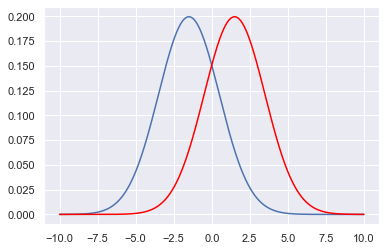

In [9]:
# now we plot the distributions
plt.plot(x, p)
plt.plot(x, q, c='red')

In [10]:
print('KL(P||Q) = %1.3f' % kl_divergence(p, q))

KL(P||Q) = 1124.917


In [11]:
# we obtain two normal distribution with mean -1.5 and 1.5 and standard deviations 2 and 4 
# using x
p = norm.pdf(x,-1.5,2)
q = norm.pdf(x,1.5,4)

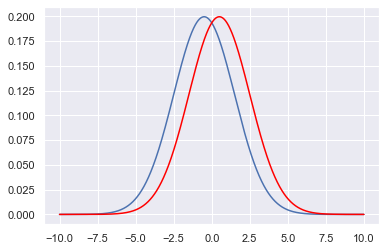

In [17]:
# now we plot the distributions
plt.plot(x, p)
plt.plot(x, q, c='red')

In [13]:
print('KL(P||Q) = %1.3f' % kl_divergence(p, q))

KL(P||Q) = 599.449


*We notice that in a way it signifies the region of that is not overlapping* 

**Let us test the fact that it is not symmetric**

In [14]:
# we obtain two normal distribution with mean -1.5 and 1.5 and standard deviations 2 and 4 
# using x but inreverse order
p = norm.pdf(x,1.5,4)
q = norm.pdf(x,-1.5,2)

In [15]:
print('KL(P||Q) = %1.3f' % kl_divergence(p, q))

KL(P||Q) = 1628.894


We know that the closer the distributions, lesser will be the KL divergence

 - Case:1 -> two normal distribution with mean -1.5 and 1.5 and standard deviation 2 
 - Case:2 -> two normal distribution with mean -0.5 and 0.5 and standard deviation 2

In [16]:
p = norm.pdf(x,-1.5,2)
q = norm.pdf(x,1.5,2)
print('KL(P||Q) = %1.3f for case 1' % kl_divergence(p, q))

p = norm.pdf(x,-0.5,2)
q = norm.pdf(x,0.5,2)
print('KL(P||Q) = %1.3f for case 2' % kl_divergence(p, q))

KL(P||Q) = 1124.917 for case 1
KL(P||Q) = 124.998 for case 2


**So in the case of t-SNE and Gaussian Mixture Models, we try to get the Gaussian distribution parameters by minimizing its KL divergence with respect to the other distribution (true distribution).**

Let us now minimize the KL divergence between two distributions using *gradient descent*.

In [20]:
# we create our first normal distribution with mean 0 and std 2
p = norm.pdf(x,0,2).reshape(1,-1)

In [21]:
# we create the next distribution with random mean and std
np.random.seed(0)
random_mean = np.random.randint(10, size=1)

In [22]:
random_mean

array([5])

In [25]:
random_std = np.random.randint(10, size=1)

In [26]:
random_std

array([3])

In [27]:
q = norm.pdf(x,random_mean,random_std).reshape(1,-1)

In [28]:
# selecting the hyper-parameters for gradient descent
learning_rate = 0.001
epochs = 100

In [29]:
# now we declare our placeholder and variables
p_pdf = tf.placeholder(tf.float64, shape=p.shape)

In [30]:
p_pdf

<tf.Tensor 'Placeholder:0' shape=(1, 20000) dtype=float64>

In [31]:
mu = tf.Variable(np.zeros(1))

In [32]:
mu

<tf.Variable 'Variable:0' shape=(1,) dtype=float64_ref>

In [33]:
sigma = tf.Variable(np.eye(1))

In [34]:
sigma

<tf.Variable 'Variable_1:0' shape=(1, 1) dtype=float64_ref>

In [35]:
normal = tf.exp(-tf.square(x - mu) / (2 * sigma))

In [36]:
normal

<tf.Tensor 'Exp:0' shape=(1, 20000) dtype=float64>

In [37]:
q = normal / tf.reduce_sum(normal)

In [38]:
q

<tf.Tensor 'truediv_1:0' shape=(1, 20000) dtype=float64>

In [40]:
# now we define the loss KL divergence
kl_divergence = tf.reduce_sum(
    tf.where(p == 0, tf.zeros(p_pdf.shape, tf.float64), p * tf.log(p / q))
)

In [41]:
# now we defibe our optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(kl_divergence)

In [42]:
# we initialize all the variables
init = tf.global_variables_initializer()

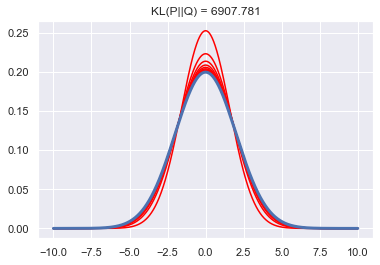

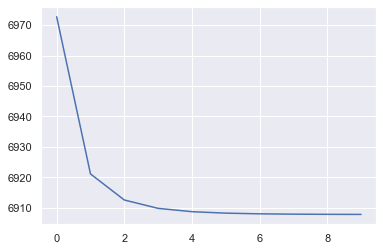

In [48]:
# now we train the model
with tf.Session() as sess:
    sess.run(init)
    
    history = []
    means = []
    variances = []
    
    for i in range(epochs):
        sess.run(optimizer, { p_pdf: p })
        
        if i % 10 == 0:
            history.append(sess.run(kl_divergence, { p_pdf: p }))
            means.append(sess.run(mu)[0])
            variances.append(sess.run(sigma)[0][0])
    
    for mean, variance in zip(means, variances):
        q_pdf = norm.pdf(x, mean, np.sqrt(variance))
        plt.plot(x, q_pdf.reshape(-1, 1), c='red')
        plt.title('KL(P||Q) = %1.3f' % history[-1])
    plt.plot(x, p.reshape(-1, 1), linewidth=3)
    plt.show()
    
    plt.plot(history)
    plt.show()
    
    sess.close()